In [ ]:
'''
This script trains the esm model on the PFR task
'''

# import libraries
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler, Sampler
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.preprocessing import LabelEncoder
from torch.nn import CrossEntropyLoss
from torchmetrics import Accuracy
from torch.optim import Adam
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig
from transformers import get_linear_schedule_with_warmup
from tqdm import tqdm
from warnings import filterwarnings
from sklearn.preprocessing import LabelEncoder

filterwarnings("ignore")

c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
class SubsetSequentialSampler(Sampler):
    '''This class is used to sample the data sequentially'''
    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return (self.indices[i] for i in range(len(self.indices)))

    def __len__(self):
        return len(self.indices)

In [ ]:
dataset = "SCOPe" # specify dataset over here from [dd, edd, tg, SCOPe]
# set fold paths
if dataset == "dd":
    path = "./dd_Fold_labels.txt"
if dataset == "edd":
    path = "./edd_Fold_labels.txt"
if dataset == "tg":
    path = "./tg_Fold_labels.txt"
if dataset == "SCOPe":
    path = "./astral_2_08_final.csv"

In [ ]:
encoder = LabelEncoder() # label encoder
if dataset == "SCOPe":  # label encode data if dataset is SCOPe
    df = pd.read_csv(path)
    sequences = df["sequence"].tolist()
    folds = encoder.fit_transform(df["fold"]).tolist()
else: # get data from the fold file if dataset is not SCOPe
    sequences, folds = [], []
    with open(path, "r") as f:
        for line in f:
            line = line.strip().split()
            sequence = line[1].upper()
            sequences.append(sequence)
            folds.append(int(line[0]))
    folds = encoder.fit_transform(np.array(folds)).tolist()
print(f"Number of sequences: {len(sequences)}")
print(f"Maximum sequence length: {len(max(sequences, key = len))}")
print(f"Number of folds: {len(set(folds))}")

Number of sequences: 6249
Maximum sequence length: 1207
Number of folds: 171


In [ ]:
# checkpoint = "facebook/esm2_t6_8M_UR50D" # smallest esm model
# checkpoint = "facebook/esm2_t12_35M_UR50D"
checkpoint = "facebook/esm2_t30_150M_UR50D" # model on which dd and tg results were achieved (computationally best option for us)
# checkpoint = "facebook/esm2_t33_650M_UR50D"
# checkpoint = "facebook/esm2_t36_3B_UR50D"
# checkpoint = "facebook/esm2_t48_15B_UR50D" # largest esm model
if checkpoint == "facebook/esm2_t6_8M_UR50D": # set model name if using base model or 30 layered model
    model_name = "base"
else:
    model_name = "30"
tokenizer = AutoTokenizer.from_pretrained(checkpoint, do_lower_case=False) # get tokenizer

In [ ]:
class ProteinDataset(Dataset):
    '''This class is used to create a dataset for the protein sequences'''
    def __init__(self, sequences, labels, tokenizer, transform=None):
        """
        Args:
            sequences (list): List of protein sequences
            labels (list): List of fold labels
            tokenizer (transformers.tokenization_utils): A tokenizer to transform protein sequences to pytorch tensors
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.sequences = sequences
        self.labels = labels
        self.tokenizer = tokenizer
        self.transform = transform

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        '''
        fn: __getitem__
        args:
            idx: index of the sequence
        return:
            sample: dictionary containing the tokenized sequence, attention mask and
        '''
        if torch.is_tensor(idx): # convert tensor to list
            idx = idx.tolist()

        # get sequence and label
        sequence = self.sequences[idx]
        label = self.labels[idx]
        # tokenize the sequence
        sample = self.tokenizer.encode_plus(sequence, add_special_tokens=True, padding="max_length", truncation=True, max_length=512, return_tensors="pt")
        sample["input_ids"] = sample["input_ids"].squeeze(0) # remove the batch dimension
        sample["attention_mask"] = sample["attention_mask"].squeeze(0) # remove the batch dimension
        sample["label"] = label # add label to the sample

        if self.transform: # apply transformation if any
            sample = self.transform(sample)

        return sample

In [ ]:
ds = ProteinDataset(sequences, folds, tokenizer) # create dataset

In [ ]:
parallel = "no" #"yes"/"no" # specify if parallel processing is to be used
if parallel == "yes": # use parallel processing
    batch_size = 16 # batch size
else: # do not use parallel processing
    batch_size = 4 # batch size
epochs = 100 # number of epochs
num_classes = torch.unique(torch.Tensor(folds)).size()[0] # number of classes

In [ ]:
# use gpu if available else cpu
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(device)

cuda


In [ ]:
def save(model, optimizer, dataset=dataset):
    '''
    fn: save model
    args:
        model: model to be saved
        optimizer: optimizer to be saved
        dataset: dataset name
    return:
        None
    '''
    filepath = f"./best_esm/esm_{model_name}_{dataset}.pth" # define the file path
    state = {
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
    } # save model and optimizer
    torch.save(state, filepath)

class EarlyStopper:
    '''
    fn: EarlyStopper
    args:
        patience: number of epochs to wait before stopping
        min_delta: minimum change in validation loss
    return:
        None
    '''
    def __init__(self, patience=1, min_delta=0): # initialize the class
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss, model, optimizer): # check if early stopping is to be done
        if validation_loss < self.min_validation_loss: # save model if validation loss is less than minimum validation loss
            self.min_validation_loss = validation_loss # update minimum validation loss
            self.counter = 0 # reset counter
            save(model, optimizer) # save model
        elif validation_loss > (self.min_validation_loss + self.min_delta): # check if validation loss is greater than minimum validation loss + minimum delta
            self.counter += 1 # increment counter
            if self.counter >= self.patience: # check if counter is greater than patience
                return True # early stop
        return False

In [ ]:
# set seed
seed = 420
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

complete_stats = {} # dictionary to store stats 

get_acc = Accuracy(task="multiclass", num_classes=num_classes) # accuracy function
get_acc.to(device) # move accuracy to device

split = "stratify" # specify split type
if split == "stratify": # stratified split
    kf = StratifiedKFold(n_splits=10, shuffle=True) 
    splits = kf.split(sequences, folds)
else: # kfold split
    kf = KFold(n_splits=10, shuffle=True)
    splits = kf.split(sequences)

for i, (train_index, val_index) in enumerate(splits): # iterate over the splits
    foldname = "Fold " + str(i+1) # fold name
    train_subsampler = SubsetRandomSampler(train_index) # train sampler
    val_subsampler = SubsetSequentialSampler(val_index) # validation sampler
    trainloader = DataLoader(ds, batch_size=batch_size, sampler=train_subsampler) # train loader
    valloader = DataLoader(ds, batch_size=batch_size, sampler=val_subsampler) # validation loader

    config = AutoConfig.from_pretrained(checkpoint) # get model config
    config.classifier_dropout = 0.1 # set dropout
    config.attention_dropout = 0.1 # set attention dropout
    config.num_labels = num_classes # set number of classes

    model = AutoModelForSequenceClassification.from_pretrained(checkpoint, config=config) # get model
    if parallel == "yes": # use parallel processing
        model = nn.DataParallel(model)
    model.to(device) # move model to device

    optimizer = Adam(model.parameters(), lr=5e-5, weight_decay=1e-3) # optimizer
    early_stopper = EarlyStopper(patience=5, min_delta=0.025) # early stopper
    training_steps = len(trainloader) * epochs # training steps
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=training_steps) # scheduler (no need to use if Adam is being used)
    
    split_stats = {"train": {"loss": [], "acc": []}, 
                   "val": {"loss": [], "acc": []}} # dictionary to store stats for each split
    
    print(foldname + ":") # print fold name
    for epoch in tqdm(range(epochs)): # iterate over the epochs
        # initialize variables
        total_train_loss = 0
        total_train_acc = 0
        avg_train_loss = 0
        avg_train_acc = 0

        model.train() # set model to train mode
        for step, batch in enumerate(trainloader): # iterate over the train loader
            input_ids = batch["input_ids"].to(device) # move input ids to device
            attention_mask = batch["attention_mask"].to(device) # move attention mask to device
            labels = torch.Tensor(batch["label"]).long().to(device) # move labels to device
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels) # get model outputs
            loss = outputs["loss"] # get loss
            preds = outputs["logits"].max(axis=1)[1] # get predictions
            optimizer.zero_grad() # zero gradients
            loss.backward() # backpropagate
            optimizer.step() # update weights
            scheduler.step() # update learning rate
            acc = get_acc(preds, labels) # get accuracy
            total_train_loss += loss.item() # update total train loss
            total_train_acc += acc.item() # update total train accuracy

        # calculate average train loss and accuracy
        avg_train_loss = total_train_loss / len(trainloader)
        avg_train_acc = total_train_acc / len(trainloader)
        split_stats["train"]["loss"].append(avg_train_loss)
        split_stats["train"]["acc"].append(avg_train_acc)

        # initialize variables
        total_val_acc = 0
        total_val_loss = 0
        avg_val_acc = 0
        avg_val_loss = 0

        model.eval() # set model to evaluation mode
        with torch.no_grad(): # do not calculate gradients
            for step, batch in enumerate(valloader): # iterate over the validation loader
                input_ids = batch["input_ids"].to(device) # move input ids to device
                attention_mask = batch["attention_mask"].to(device) # move attention mask to device
                labels = batch["label"].long().to(device) # move labels to device
                outputs = model(input_ids, attention_mask=attention_mask, labels=labels) # get model outputs
                preds = outputs["logits"].max(axis=1)[1] # get predictions
                acc = get_acc(preds, labels) # get accuracy
                total_val_loss += outputs["loss"].item() # update total validation loss
                total_val_acc += acc.item() # update total validation accuracy

        # calculate average validation loss and accuracy
        avg_val_loss = total_val_loss / len(valloader)
        avg_val_acc = total_val_acc / len(valloader)
        split_stats["val"]["loss"].append(avg_val_loss)
        split_stats["val"]["acc"].append(avg_val_acc)

        if early_stopper.early_stop(avg_val_loss, model, optimizer): # check if early stopping is to be done
            print(f"\nEarly Stopping!!! Epoch {epoch+1} ->\nTrain Loss: {avg_train_loss} | Train ACC: {avg_train_acc}\nVal Loss: {avg_val_loss} | Val Acc: {avg_val_acc}")
            break

        print(f"\nEpoch {epoch+1} ->\nTrain Loss: {avg_train_loss} | Train ACC: {avg_train_acc}\nVal Loss: {avg_val_loss} | Val Acc: {avg_val_acc}")

    complete_stats[foldname] = split_stats # update complete stats

Some weights of the model checkpoint at facebook/esm2_t30_150M_UR50D were not used when initializing EsmForSequenceClassification: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing EsmForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing EsmForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at facebook/esm2_t30_150M_UR50D and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias'

Fold 1:


  1%|          | 1/100 [21:38<35:42:16, 1298.35s/it]


Epoch 1 ->
Train Loss: 3.358335287078346 | Train ACC: 0.39349217638691325
Val Loss: 2.027497092487326 | Val Acc: 0.697452229299363


  2%|▏         | 2/100 [43:21<35:24:52, 1300.94s/it]


Epoch 2 ->
Train Loss: 1.6034906448592374 | Train ACC: 0.737375533428165
Val Loss: 1.3678032279868795 | Val Acc: 0.785031847133758


  3%|▎         | 3/100 [1:05:02<35:03:15, 1300.99s/it]


Epoch 3 ->
Train Loss: 1.0229420204187185 | Train ACC: 0.8182788051209103
Val Loss: 1.0123754855079257 | Val Acc: 0.804140127388535


  4%|▍         | 4/100 [1:26:41<34:40:36, 1300.38s/it]


Epoch 4 ->
Train Loss: 0.7448615844468791 | Train ACC: 0.857574679943101
Val Loss: 1.2728533185247308 | Val Acc: 0.7563694267515924


  5%|▌         | 5/100 [1:48:25<34:20:42, 1301.50s/it]


Epoch 5 ->
Train Loss: 0.592540629213387 | Train ACC: 0.8824679943100996
Val Loss: 0.9117461687760653 | Val Acc: 0.8105095541401274


  6%|▌         | 6/100 [2:10:04<33:57:50, 1300.75s/it]


Epoch 6 ->
Train Loss: 0.5349699265361998 | Train ACC: 0.8878022759601707
Val Loss: 1.013307085139143 | Val Acc: 0.7611464968152867


  7%|▋         | 7/100 [2:31:43<33:35:19, 1300.21s/it]


Epoch 7 ->
Train Loss: 0.4392137315242179 | Train ACC: 0.909850640113798
Val Loss: 1.1327956633191485 | Val Acc: 0.7834394904458599


  8%|▊         | 8/100 [2:53:22<33:13:14, 1299.94s/it]


Epoch 8 ->
Train Loss: 0.3929969808056945 | Train ACC: 0.9196301564722618
Val Loss: 1.21474975687422 | Val Acc: 0.7563694267515924


  9%|▉         | 9/100 [3:15:02<32:51:17, 1299.76s/it]


Epoch 9 ->
Train Loss: 0.37155311109476946 | Train ACC: 0.92549786628734
Val Loss: 1.1094889404329287 | Val Acc: 0.7611464968152867


  9%|▉         | 9/100 [3:36:40<36:30:53, 1444.54s/it]


Early Stopping!!! Epoch 10 ->
Train Loss: 0.32751844165075683 | Train ACC: 0.9329658605974396
Val Loss: 1.1205844822648177 | Val Acc: 0.7914012738853503



Some weights of the model checkpoint at facebook/esm2_t30_150M_UR50D were not used when initializing EsmForSequenceClassification: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing EsmForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing EsmForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at facebook/esm2_t30_150M_UR50D and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias

Fold 2:


  1%|          | 1/100 [21:43<35:51:08, 1303.72s/it]


Epoch 1 ->
Train Loss: 3.4526772856987895 | Train ACC: 0.38140113798008535
Val Loss: 2.180682872700843 | Val Acc: 0.6321656050955414


  2%|▏         | 2/100 [43:27<35:29:15, 1303.63s/it]


Epoch 2 ->
Train Loss: 1.6332653034186975 | Train ACC: 0.7331081081081081
Val Loss: 1.3431944807599874 | Val Acc: 0.7531847133757962


  3%|▎         | 3/100 [1:05:09<35:06:21, 1302.90s/it]


Epoch 3 ->
Train Loss: 1.0597067493733394 | Train ACC: 0.8076102418207681
Val Loss: 1.0691508159610876 | Val Acc: 0.804140127388535


  4%|▍         | 4/100 [1:26:49<34:43:09, 1301.98s/it]


Epoch 4 ->
Train Loss: 0.8041313719752895 | Train ACC: 0.8465504978662873
Val Loss: 1.16812011665979 | Val Acc: 0.7738853503184714


  5%|▌         | 5/100 [1:48:32<34:22:05, 1302.38s/it]


Epoch 5 ->
Train Loss: 0.6526752127358322 | Train ACC: 0.8705547652916074
Val Loss: 0.9476232544643579 | Val Acc: 0.7929936305732485


  6%|▌         | 6/100 [2:09:58<33:51:16, 1296.56s/it]


Epoch 6 ->
Train Loss: 0.5703585817018897 | Train ACC: 0.8835348506401138
Val Loss: 1.5533231149344544 | Val Acc: 0.6942675159235668


  7%|▋         | 7/100 [2:31:17<33:20:52, 1290.89s/it]


Epoch 7 ->
Train Loss: 0.46265927129550966 | Train ACC: 0.9009601706970128
Val Loss: 0.9793965630055328 | Val Acc: 0.7882165605095541


  8%|▊         | 8/100 [2:52:36<32:53:38, 1287.16s/it]


Epoch 8 ->
Train Loss: 0.47565855007025165 | Train ACC: 0.8997155049786629
Val Loss: 1.1656667281648108 | Val Acc: 0.7643312101910829


  9%|▉         | 9/100 [3:13:58<32:29:47, 1285.58s/it]


Epoch 9 ->
Train Loss: 0.3605710829251776 | Train ACC: 0.9246088193456614
Val Loss: 0.9197437576623337 | Val Acc: 0.8009554140127388


 10%|█         | 10/100 [3:35:31<32:11:53, 1287.93s/it]


Epoch 10 ->
Train Loss: 0.3274397310389505 | Train ACC: 0.9290540540540541
Val Loss: 1.1235572694842317 | Val Acc: 0.7563694267515924


 11%|█         | 11/100 [3:57:03<31:51:57, 1288.97s/it]


Epoch 11 ->
Train Loss: 0.33336410512167375 | Train ACC: 0.9334992887624467
Val Loss: 1.2002660182043672 | Val Acc: 0.7722929936305732


 12%|█▏        | 12/100 [4:18:34<31:31:29, 1289.65s/it]


Epoch 12 ->
Train Loss: 0.24891678112390772 | Train ACC: 0.9511024182076814
Val Loss: 1.2663000974119019 | Val Acc: 0.7436305732484076


 13%|█▎        | 13/100 [4:40:04<31:10:18, 1289.86s/it]


Epoch 13 ->
Train Loss: 0.262270949876491 | Train ACC: 0.9505689900426743
Val Loss: 1.2008683405858078 | Val Acc: 0.7722929936305732


 13%|█▎        | 13/100 [5:01:33<33:38:08, 1391.82s/it]


Early Stopping!!! Epoch 14 ->
Train Loss: 0.2016131953974844 | Train ACC: 0.9644381223328592
Val Loss: 1.3451074408915986 | Val Acc: 0.7245222929936306



Some weights of the model checkpoint at facebook/esm2_t30_150M_UR50D were not used when initializing EsmForSequenceClassification: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing EsmForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing EsmForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at facebook/esm2_t30_150M_UR50D and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias

Fold 3:


  1%|          | 1/100 [21:36<35:39:21, 1296.58s/it]


Epoch 1 ->
Train Loss: 3.3407058184847216 | Train ACC: 0.41127311522048365
Val Loss: 2.0341401455603587 | Val Acc: 0.6926751592356688


  2%|▏         | 2/100 [43:10<35:15:16, 1295.06s/it]


Epoch 2 ->
Train Loss: 1.5771908295628314 | Train ACC: 0.7443100995732574
Val Loss: 1.2816816698285236 | Val Acc: 0.7834394904458599


  3%|▎         | 3/100 [1:04:49<34:56:14, 1296.65s/it]


Epoch 3 ->
Train Loss: 1.0154768292425176 | Train ACC: 0.811877667140825
Val Loss: 1.053286545987057 | Val Acc: 0.7834394904458599


  4%|▍         | 4/100 [1:26:22<34:32:41, 1295.43s/it]


Epoch 4 ->
Train Loss: 0.7892139326571719 | Train ACC: 0.8477951635846372
Val Loss: 1.0908255713285915 | Val Acc: 0.804140127388535


  5%|▌         | 5/100 [1:47:53<34:08:19, 1293.68s/it]


Epoch 5 ->
Train Loss: 0.6513114281854516 | Train ACC: 0.8703769559032717
Val Loss: 1.1435357040079062 | Val Acc: 0.7691082802547771


  6%|▌         | 6/100 [2:09:23<33:45:10, 1292.66s/it]


Epoch 6 ->
Train Loss: 0.5532285337565549 | Train ACC: 0.8851351351351351
Val Loss: 1.1400571668425659 | Val Acc: 0.7579617834394905


  7%|▋         | 7/100 [2:30:58<33:24:24, 1293.16s/it]


Epoch 7 ->
Train Loss: 0.46380647462044194 | Train ACC: 0.8982930298719772
Val Loss: 0.9621127275438611 | Val Acc: 0.8136942675159236


  8%|▊         | 8/100 [2:52:29<33:02:12, 1292.74s/it]


Epoch 8 ->
Train Loss: 0.4188578347205204 | Train ACC: 0.9126955903271693
Val Loss: 1.0377432411406071 | Val Acc: 0.7945859872611465


  9%|▉         | 9/100 [3:13:50<32:34:42, 1288.82s/it]


Epoch 9 ->
Train Loss: 0.33283705943115693 | Train ACC: 0.9324324324324325
Val Loss: 1.0479832158222273 | Val Acc: 0.8009554140127388


 10%|█         | 10/100 [3:35:09<32:09:00, 1286.00s/it]


Epoch 10 ->
Train Loss: 0.35776721085633706 | Train ACC: 0.927275960170697
Val Loss: 1.096173169663781 | Val Acc: 0.7786624203821656


 11%|█         | 11/100 [3:56:29<31:44:40, 1284.05s/it]


Epoch 11 ->
Train Loss: 0.2848997451109973 | Train ACC: 0.9439900426742532
Val Loss: 1.2533523987972766 | Val Acc: 0.7531847133757962


 11%|█         | 11/100 [4:17:49<34:46:04, 1406.34s/it]


Early Stopping!!! Epoch 12 ->
Train Loss: 0.25718950836523136 | Train ACC: 0.9505689900426743
Val Loss: 1.6665978468628304 | Val Acc: 0.678343949044586



Some weights of the model checkpoint at facebook/esm2_t30_150M_UR50D were not used when initializing EsmForSequenceClassification: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing EsmForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing EsmForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at facebook/esm2_t30_150M_UR50D and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias

Fold 4:


  1%|          | 1/100 [21:48<35:58:24, 1308.13s/it]


Epoch 1 ->
Train Loss: 3.4205840286582836 | Train ACC: 0.3902916073968706
Val Loss: 2.088738589007763 | Val Acc: 0.660828025477707


  2%|▏         | 2/100 [43:35<35:35:24, 1307.40s/it]


Epoch 2 ->
Train Loss: 1.5882131015010188 | Train ACC: 0.7462660028449503
Val Loss: 1.41212349188081 | Val Acc: 0.7515923566878981


  3%|▎         | 3/100 [1:05:21<35:13:01, 1307.03s/it]


Epoch 3 ->
Train Loss: 1.0239006438230298 | Train ACC: 0.8204125177809388
Val Loss: 1.2065164790886223 | Val Acc: 0.7722929936305732


  4%|▍         | 4/100 [1:27:07<34:50:44, 1306.71s/it]


Epoch 4 ->
Train Loss: 0.7906628890707559 | Train ACC: 0.846728307254623
Val Loss: 1.2003721286346958 | Val Acc: 0.7738853503184714


  5%|▌         | 5/100 [1:48:48<34:25:30, 1304.53s/it]


Epoch 5 ->
Train Loss: 0.662639351757071 | Train ACC: 0.868421052631579
Val Loss: 1.3587124242097328 | Val Acc: 0.7388535031847133


  6%|▌         | 6/100 [2:10:29<34:02:02, 1303.43s/it]


Epoch 6 ->
Train Loss: 0.5058350484125359 | Train ACC: 0.8947368421052632
Val Loss: 1.4707713967580704 | Val Acc: 0.7308917197452229


  7%|▋         | 7/100 [2:32:11<33:39:26, 1302.86s/it]


Epoch 7 ->
Train Loss: 0.4970056497290529 | Train ACC: 0.8988264580369844
Val Loss: 1.446329110918958 | Val Acc: 0.7531847133757962


  8%|▊         | 8/100 [2:53:53<33:17:05, 1302.45s/it]


Epoch 8 ->
Train Loss: 0.4009628306331105 | Train ACC: 0.9208748221906117
Val Loss: 1.3272282880238573 | Val Acc: 0.732484076433121


  8%|▊         | 8/100 [3:15:34<37:29:04, 1466.79s/it]


Early Stopping!!! Epoch 9 ->
Train Loss: 0.3845400131296944 | Train ACC: 0.9215860597439545
Val Loss: 1.2472844289283558 | Val Acc: 0.7547770700636943



Some weights of the model checkpoint at facebook/esm2_t30_150M_UR50D were not used when initializing EsmForSequenceClassification: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing EsmForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing EsmForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at facebook/esm2_t30_150M_UR50D and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias

Fold 5:


  1%|          | 1/100 [21:46<35:55:27, 1306.34s/it]


Epoch 1 ->
Train Loss: 3.420704397504055 | Train ACC: 0.39847083926031296
Val Loss: 2.2579764027124756 | Val Acc: 0.6544585987261147


  2%|▏         | 2/100 [43:31<35:32:35, 1305.67s/it]


Epoch 2 ->
Train Loss: 1.6361550376227239 | Train ACC: 0.7352418207681366
Val Loss: 1.5153120131747928 | Val Acc: 0.732484076433121


  3%|▎         | 3/100 [1:05:13<35:08:08, 1304.00s/it]


Epoch 3 ->
Train Loss: 1.0359544713834399 | Train ACC: 0.8129445234708392
Val Loss: 1.7594406489686223 | Val Acc: 0.6735668789808917


  4%|▍         | 4/100 [1:26:57<34:46:20, 1303.96s/it]


Epoch 4 ->
Train Loss: 0.7591159017266411 | Train ACC: 0.8572190611664295
Val Loss: 1.065678216196644 | Val Acc: 0.7977707006369427


  5%|▌         | 5/100 [1:48:41<34:24:49, 1304.10s/it]


Epoch 5 ->
Train Loss: 0.6380162792675101 | Train ACC: 0.8712660028449503
Val Loss: 1.0286949264644911 | Val Acc: 0.7898089171974523


  6%|▌         | 6/100 [2:10:05<33:52:13, 1297.16s/it]


Epoch 6 ->
Train Loss: 0.5544185604811361 | Train ACC: 0.8844238975817923
Val Loss: 0.9991043287649704 | Val Acc: 0.785031847133758


  7%|▋         | 7/100 [2:31:40<33:29:40, 1296.56s/it]


Epoch 7 ->
Train Loss: 0.4468700937061686 | Train ACC: 0.9054054054054054
Val Loss: 1.0831466791854731 | Val Acc: 0.7818471337579618


  8%|▊         | 8/100 [2:53:21<33:10:12, 1297.96s/it]


Epoch 8 ->
Train Loss: 0.4470828200271817 | Train ACC: 0.9094950213371266
Val Loss: 1.0130304644317336 | Val Acc: 0.7914012738853503


  9%|▉         | 9/100 [3:15:02<32:49:44, 1298.73s/it]


Epoch 9 ->
Train Loss: 0.33690938696558 | Train ACC: 0.9278093883357041
Val Loss: 1.1542129534397536 | Val Acc: 0.7786624203821656


 10%|█         | 10/100 [3:36:43<32:29:05, 1299.40s/it]


Epoch 10 ->
Train Loss: 0.3502506776471062 | Train ACC: 0.9276315789473685
Val Loss: 1.0732329772595481 | Val Acc: 0.7882165605095541


 11%|█         | 11/100 [3:58:24<32:08:08, 1299.87s/it]


Epoch 11 ->
Train Loss: 0.28344081272437355 | Train ACC: 0.944701280227596
Val Loss: 1.060682251485907 | Val Acc: 0.7834394904458599


 11%|█         | 11/100 [4:20:04<35:04:15, 1418.61s/it]


Early Stopping!!! Epoch 12 ->
Train Loss: 0.2458165661325204 | Train ACC: 0.9541251778093883
Val Loss: 1.6912381301432327 | Val Acc: 0.6640127388535032



Some weights of the model checkpoint at facebook/esm2_t30_150M_UR50D were not used when initializing EsmForSequenceClassification: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing EsmForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing EsmForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at facebook/esm2_t30_150M_UR50D and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias

Fold 6:


  1%|          | 1/100 [21:45<35:54:52, 1305.98s/it]


Epoch 1 ->
Train Loss: 3.3371056776552077 | Train ACC: 0.41607396870554764
Val Loss: 2.317325802128406 | Val Acc: 0.6130573248407644


  2%|▏         | 2/100 [43:31<35:32:21, 1305.53s/it]


Epoch 2 ->
Train Loss: 1.628708928743984 | Train ACC: 0.730796586059744
Val Loss: 1.3390263763914823 | Val Acc: 0.7770700636942676


  3%|▎         | 3/100 [1:05:15<35:09:39, 1304.95s/it]


Epoch 3 ->
Train Loss: 1.0241523657529317 | Train ACC: 0.8154338549075392
Val Loss: 1.083022671099159 | Val Acc: 0.7977707006369427


  4%|▍         | 4/100 [1:26:56<34:45:30, 1303.44s/it]


Epoch 4 ->
Train Loss: 0.7480112069152602 | Train ACC: 0.8561522048364154
Val Loss: 1.1170173390015106 | Val Acc: 0.7722929936305732


  5%|▌         | 5/100 [1:48:39<34:23:37, 1303.34s/it]


Epoch 5 ->
Train Loss: 0.6295804850933319 | Train ACC: 0.8723328591749644
Val Loss: 0.9587318843325517 | Val Acc: 0.8073248407643312


  6%|▌         | 6/100 [2:10:20<34:00:31, 1302.47s/it]


Epoch 6 ->
Train Loss: 0.575792862223607 | Train ACC: 0.8796230440967283
Val Loss: 1.0849543204293794 | Val Acc: 0.7722929936305732


  7%|▋         | 7/100 [2:32:00<33:37:33, 1301.65s/it]


Epoch 7 ->
Train Loss: 0.4539726858251168 | Train ACC: 0.9018492176386913
Val Loss: 0.9908020232009233 | Val Acc: 0.804140127388535


  8%|▊         | 8/100 [2:53:40<33:15:01, 1301.10s/it]


Epoch 8 ->
Train Loss: 0.4537919277443178 | Train ACC: 0.9025604551920341
Val Loss: 1.1238179089987923 | Val Acc: 0.7754777070063694


  9%|▉         | 9/100 [3:15:19<32:52:36, 1300.63s/it]


Epoch 9 ->
Train Loss: 0.38821289176883106 | Train ACC: 0.9185633001422475
Val Loss: 1.0184050768192643 | Val Acc: 0.7993630573248408


  9%|▉         | 9/100 [3:37:00<36:34:09, 1446.69s/it]


Early Stopping!!! Epoch 10 ->
Train Loss: 0.33417186172709534 | Train ACC: 0.9311877667140825
Val Loss: 1.1445390818355854 | Val Acc: 0.7738853503184714



Some weights of the model checkpoint at facebook/esm2_t30_150M_UR50D were not used when initializing EsmForSequenceClassification: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing EsmForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing EsmForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at facebook/esm2_t30_150M_UR50D and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias

Fold 7:


  1%|          | 1/100 [21:45<35:54:24, 1305.70s/it]


Epoch 1 ->
Train Loss: 3.347877943996939 | Train ACC: 0.40665007112375534
Val Loss: 2.1608611875848407 | Val Acc: 0.678343949044586


  2%|▏         | 2/100 [43:31<35:32:23, 1305.54s/it]


Epoch 2 ->
Train Loss: 1.612941955662681 | Train ACC: 0.7380867709815079
Val Loss: 1.542323649451611 | Val Acc: 0.7515923566878981


  3%|▎         | 3/100 [1:05:15<35:09:28, 1304.83s/it]


Epoch 3 ->
Train Loss: 1.070058291932968 | Train ACC: 0.8109886201991465
Val Loss: 1.2364259894676268 | Val Acc: 0.767515923566879


  4%|▍         | 4/100 [1:26:58<34:46:58, 1304.36s/it]


Epoch 4 ->
Train Loss: 0.7927935834388496 | Train ACC: 0.8424608819345661
Val Loss: 1.0126791505831156 | Val Acc: 0.7786624203821656


  5%|▌         | 5/100 [1:48:39<34:23:09, 1303.05s/it]


Epoch 5 ->
Train Loss: 0.7019577998135392 | Train ACC: 0.8616642958748222
Val Loss: 1.037608514148386 | Val Acc: 0.7977707006369427


  6%|▌         | 6/100 [2:10:20<34:00:13, 1302.27s/it]


Epoch 6 ->
Train Loss: 0.5642033249151709 | Train ACC: 0.8814011379800853
Val Loss: 1.2907734925674785 | Val Acc: 0.7468152866242038


  7%|▋         | 7/100 [2:32:01<33:37:52, 1301.85s/it]


Epoch 7 ->
Train Loss: 0.5146441010521144 | Train ACC: 0.8881578947368421
Val Loss: 1.127462562185469 | Val Acc: 0.7691082802547771


  8%|▊         | 8/100 [2:53:41<33:15:34, 1301.46s/it]


Epoch 8 ->
Train Loss: 0.45592838240744993 | Train ACC: 0.9043385490753911
Val Loss: 1.095432326980647 | Val Acc: 0.7802547770700637


  9%|▉         | 9/100 [3:15:22<32:53:21, 1301.12s/it]


Epoch 9 ->
Train Loss: 0.32688863096681886 | Train ACC: 0.9326102418207681
Val Loss: 1.0881103272282868 | Val Acc: 0.7802547770700637


  9%|▉         | 9/100 [3:37:02<36:34:32, 1446.95s/it]


Early Stopping!!! Epoch 10 ->
Train Loss: 0.38020286266294545 | Train ACC: 0.919452347083926
Val Loss: 1.4294226927249722 | Val Acc: 0.7245222929936306



Some weights of the model checkpoint at facebook/esm2_t30_150M_UR50D were not used when initializing EsmForSequenceClassification: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing EsmForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing EsmForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at facebook/esm2_t30_150M_UR50D and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias

Fold 8:


  1%|          | 1/100 [21:45<35:53:23, 1305.09s/it]


Epoch 1 ->
Train Loss: 3.376278880374191 | Train ACC: 0.3993598862019915
Val Loss: 2.1482880414481373 | Val Acc: 0.6321656050955414


  2%|▏         | 2/100 [43:29<35:31:02, 1304.72s/it]


Epoch 2 ->
Train Loss: 1.6240549404359559 | Train ACC: 0.7473328591749644
Val Loss: 1.356456142393457 | Val Acc: 0.7691082802547771


  3%|▎         | 3/100 [1:05:11<35:07:24, 1303.55s/it]


Epoch 3 ->
Train Loss: 1.013896756515352 | Train ACC: 0.8205903271692745
Val Loss: 1.054592698646389 | Val Acc: 0.7945859872611465


  4%|▍         | 4/100 [1:26:51<34:43:16, 1302.05s/it]


Epoch 4 ->
Train Loss: 0.8169357763341023 | Train ACC: 0.8451280227596017
Val Loss: 1.1360715958022862 | Val Acc: 0.7563694267515924


  5%|▌         | 5/100 [1:48:34<34:22:06, 1302.38s/it]


Epoch 5 ->
Train Loss: 0.6556164803325197 | Train ACC: 0.8680654338549075
Val Loss: 1.0405862660971796 | Val Acc: 0.7834394904458599


  6%|▌         | 6/100 [2:10:14<33:59:09, 1301.59s/it]


Epoch 6 ->
Train Loss: 0.5335771516747084 | Train ACC: 0.8878022759601707
Val Loss: 1.0859812018105606 | Val Acc: 0.767515923566879


  7%|▋         | 7/100 [2:31:54<33:36:37, 1301.05s/it]


Epoch 7 ->
Train Loss: 0.4606539229100642 | Train ACC: 0.9009601706970128
Val Loss: 1.173172034696931 | Val Acc: 0.7691082802547771


  8%|▊         | 8/100 [2:53:33<33:14:03, 1300.47s/it]


Epoch 8 ->
Train Loss: 0.4072372086868114 | Train ACC: 0.914651493598862
Val Loss: 1.28798203116615 | Val Acc: 0.7627388535031847


  9%|▉         | 9/100 [3:15:13<32:51:55, 1300.17s/it]


Epoch 9 ->
Train Loss: 0.3677333721044509 | Train ACC: 0.92549786628734
Val Loss: 1.0594041259591556 | Val Acc: 0.7945859872611465


 10%|█         | 10/100 [3:36:53<32:30:18, 1300.21s/it]


Epoch 10 ->
Train Loss: 0.2851472327099506 | Train ACC: 0.9461237553342816
Val Loss: 1.302477897818135 | Val Acc: 0.7277070063694268


 10%|█         | 10/100 [3:58:33<35:47:04, 1431.38s/it]


Early Stopping!!! Epoch 11 ->
Train Loss: 0.2973361294607302 | Train ACC: 0.9388335704125178
Val Loss: 1.360551783981122 | Val Acc: 0.7181528662420382



Some weights of the model checkpoint at facebook/esm2_t30_150M_UR50D were not used when initializing EsmForSequenceClassification: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing EsmForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing EsmForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at facebook/esm2_t30_150M_UR50D and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias

Fold 9:


  1%|          | 1/100 [21:45<35:53:31, 1305.17s/it]


Epoch 1 ->
Train Loss: 3.402237766985364 | Train ACC: 0.39349217638691325
Val Loss: 2.5990823269554766 | Val Acc: 0.5907643312101911


  2%|▏         | 2/100 [43:30<35:31:47, 1305.18s/it]


Epoch 2 ->
Train Loss: 1.6250861162481403 | Train ACC: 0.7354196301564723
Val Loss: 1.3555690849876139 | Val Acc: 0.7722929936305732


  3%|▎         | 3/100 [1:05:19<35:13:10, 1307.12s/it]


Epoch 3 ->
Train Loss: 1.061481970877706 | Train ACC: 0.8086770981507824
Val Loss: 1.2618347995078107 | Val Acc: 0.7595541401273885


  4%|▍         | 4/100 [1:27:08<34:52:14, 1307.65s/it]


Epoch 4 ->
Train Loss: 0.8066959501513059 | Train ACC: 0.8453058321479374
Val Loss: 0.9932411513498919 | Val Acc: 0.7914012738853503


  5%|▌         | 5/100 [1:48:49<34:27:04, 1305.52s/it]


Epoch 5 ->
Train Loss: 0.6461009074964297 | Train ACC: 0.8691322901849218
Val Loss: 1.047645739540695 | Val Acc: 0.7802547770700637


  6%|▌         | 6/100 [2:10:32<34:03:28, 1304.35s/it]


Epoch 6 ->
Train Loss: 0.5775501024664232 | Train ACC: 0.8803342816500711
Val Loss: 1.004109342457952 | Val Acc: 0.7961783439490446


  7%|▋         | 7/100 [2:32:14<33:40:36, 1303.62s/it]


Epoch 7 ->
Train Loss: 0.45427666105340586 | Train ACC: 0.9046941678520626
Val Loss: 1.273835522211661 | Val Acc: 0.7420382165605095


  8%|▊         | 8/100 [2:53:56<33:18:27, 1303.34s/it]


Epoch 8 ->
Train Loss: 0.4613313666474641 | Train ACC: 0.902027027027027
Val Loss: 1.2425854742930384 | Val Acc: 0.7468152866242038


  9%|▉         | 9/100 [3:15:40<32:56:37, 1303.27s/it]


Epoch 9 ->
Train Loss: 0.3722485728438673 | Train ACC: 0.9217638691322901
Val Loss: 1.1819203480645113 | Val Acc: 0.767515923566879


  9%|▉         | 9/100 [3:37:22<36:37:58, 1449.21s/it]


Early Stopping!!! Epoch 10 ->
Train Loss: 0.3295799205947408 | Train ACC: 0.9370554765291608
Val Loss: 1.311169470986648 | Val Acc: 0.7531847133757962



Some weights of the model checkpoint at facebook/esm2_t30_150M_UR50D were not used when initializing EsmForSequenceClassification: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing EsmForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing EsmForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at facebook/esm2_t30_150M_UR50D and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias

Fold 10:


  1%|          | 1/100 [21:48<35:58:29, 1308.18s/it]


Epoch 1 ->
Train Loss: 3.3618633293711553 | Train ACC: 0.4161336176261549
Val Loss: 2.0700855537389335 | Val Acc: 0.7147435897435898


  2%|▏         | 2/100 [43:34<35:35:10, 1307.25s/it]


Epoch 2 ->
Train Loss: 1.5955992784952135 | Train ACC: 0.750177683013504
Val Loss: 1.2773950329432502 | Val Acc: 0.7948717948717948


  3%|▎         | 3/100 [1:05:21<35:13:04, 1307.06s/it]


Epoch 3 ->
Train Loss: 1.0070512905086748 | Train ACC: 0.8264036958066808
Val Loss: 1.0797368586779788 | Val Acc: 0.7916666666666666


  4%|▍         | 4/100 [1:27:07<34:50:39, 1306.66s/it]


Epoch 4 ->
Train Loss: 0.7428819105616892 | Train ACC: 0.8585643212508884
Val Loss: 1.0108828283547877 | Val Acc: 0.8076923076923077


  5%|▌         | 5/100 [1:48:50<34:26:52, 1305.40s/it]


Epoch 5 ->
Train Loss: 0.6279536734699843 | Train ACC: 0.8736673773987207
Val Loss: 1.0732802539371336 | Val Acc: 0.7676282051282052


  6%|▌         | 6/100 [2:10:33<34:03:25, 1304.32s/it]


Epoch 6 ->
Train Loss: 0.5198995253599402 | Train ACC: 0.8937455579246624
Val Loss: 1.0340118475724012 | Val Acc: 0.8012820512820513


  7%|▋         | 7/100 [2:32:19<33:42:36, 1304.91s/it]


Epoch 7 ->
Train Loss: 0.4547638451672598 | Train ACC: 0.9074271499644634
Val Loss: 0.9060105353575916 | Val Acc: 0.8060897435897436


  8%|▊         | 8/100 [2:54:02<33:19:54, 1304.29s/it]


Epoch 8 ->
Train Loss: 0.41765788058282355 | Train ACC: 0.912046908315565
Val Loss: 1.2483568732561066 | Val Acc: 0.7644230769230769


  9%|▉         | 9/100 [3:15:44<32:57:15, 1303.69s/it]


Epoch 9 ->
Train Loss: 0.3222028937726265 | Train ACC: 0.9319474058280028
Val Loss: 1.1445326476375788 | Val Acc: 0.7596153846153846


 10%|█         | 10/100 [3:37:27<32:35:01, 1303.35s/it]


Epoch 10 ->
Train Loss: 0.3547310237623831 | Train ACC: 0.927683013503909
Val Loss: 1.1700596626048 | Val Acc: 0.7612179487179487


 11%|█         | 11/100 [3:59:10<32:13:16, 1303.33s/it]


Epoch 11 ->
Train Loss: 0.26813027420324126 | Train ACC: 0.9465174129353234
Val Loss: 1.1562808164326737 | Val Acc: 0.7692307692307693


 11%|█         | 11/100 [4:20:52<35:10:45, 1422.99s/it]


Early Stopping!!! Epoch 12 ->
Train Loss: 0.28258727354777935 | Train ACC: 0.9456289978678039
Val Loss: 1.6481887801723458 | Val Acc: 0.6682692307692307


In [12]:
splits = list(complete_stats.keys())
train_acc = []
val_acc = []
for split in splits:
    train_acc.append(max(complete_stats[split]["train"]["acc"]))
    val_acc.append(max(complete_stats[split]["val"]["acc"]))
max_train_acc = sum(train_acc) / len(splits)
max_val_acc = sum(val_acc) / len(splits)
print("Train accuracies:\n", train_acc)
print("Validation accuracies:\n", val_acc)
print(f"Average Train Acc: {max_train_acc} | Average Val Acc: {max_val_acc}")

Train accuracies:
 [0.9329658605974396, 0.9644381223328592, 0.9505689900426743, 0.9215860597439545, 0.9541251778093883, 0.9311877667140825, 0.9326102418207681, 0.9461237553342816, 0.9370554765291608, 0.9465174129353234]
Validation accuracies:
 [0.8105095541401274, 0.804140127388535, 0.8136942675159236, 0.7738853503184714, 0.7977707006369427, 0.8073248407643312, 0.7977707006369427, 0.7945859872611465, 0.7961783439490446, 0.8076923076923077]
Average Train Acc: 0.9417178863859931 | Average Val Acc: 0.8003552180303772


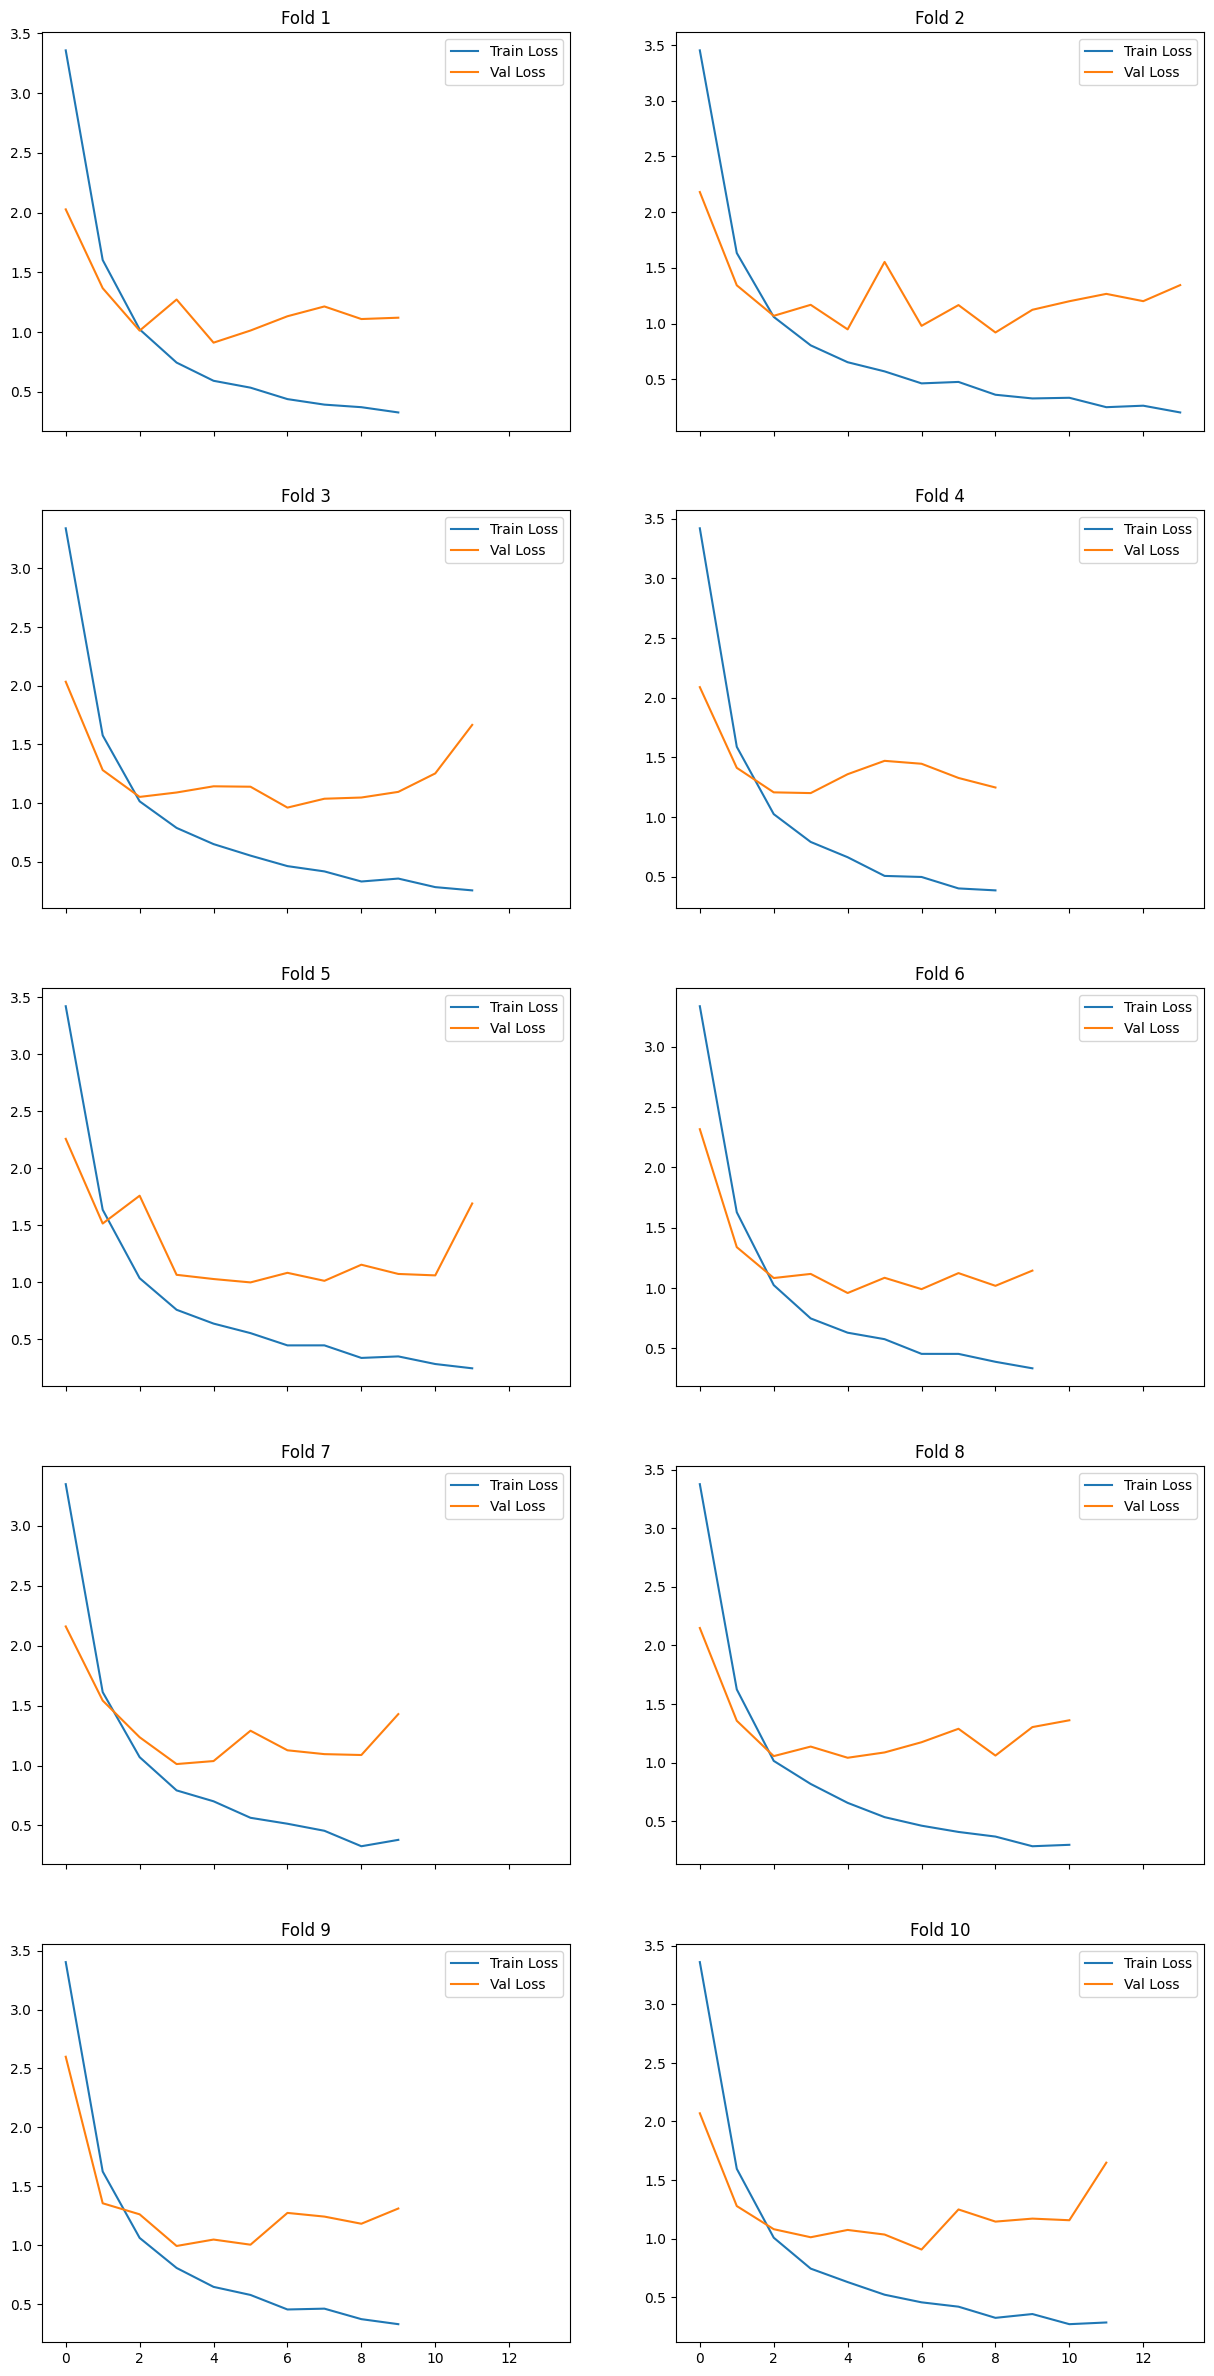

In [ ]:
# plot loss curves for each fold

import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(5, 2, sharex=True, figsize=(15, 30))

for i in range(5):
    sns.lineplot(x=range(len(complete_stats[splits[2*i]]["train"]["loss"])), y=complete_stats[splits[2*i]]["train"]["loss"], ax=ax[i][0], label="Train Loss")
    sns.lineplot(x=range(len(complete_stats[splits[2*i]]["val"]["loss"])), y=complete_stats[splits[2*i]]["val"]["loss"], ax=ax[i][0], label="Val Loss")
    sns.lineplot(x=range(len(complete_stats[splits[2*(i)+1]]["train"]["loss"])), y=complete_stats[splits[2*(i)+1]]["train"]["loss"], ax=ax[i][1], label="Train Loss")
    sns.lineplot(x=range(len(complete_stats[splits[2*(i)+1]]["val"]["loss"])), y=complete_stats[splits[2*(i)+1]]["val"]["loss"], ax=ax[i][1], label="Val Loss")
    ax[i][0].set_title(splits[2*i])
    ax[i][1].set_title(splits[2*(i)+1])
    
# plt.show()
loss_plot = plt.gcf()
loss_plot.savefig(f"./esm_base_loss_{dataset}.png")

In [ ]:
file = open(f"./{dataset}_results.txt", "w") # write results to a file
file.write(f"{dataset} Results:\nAverage Train Acc: {max_train_acc}\nAverage Validation Acc: {max_val_acc}")
file.close()